<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Quantum-time-estimation" data-toc-modified-id="Quantum-time-estimation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Quantum time estimation</a></span><ul class="toc-item"><li><span><a href="#Constants" data-toc-modified-id="Constants-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Old-scripts-by-Tom" data-toc-modified-id="Old-scripts-by-Tom-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Old scripts by Tom</a></span></li></ul></div>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from cartesian_explorer import Explorer
import cartesian_explorer as caex

import qtensor
import time

import socket

In [3]:
cache = caex.caches.JobLibCache("../caex_cache/energy_eff")
parallel = None
ex = Explorer(cache=cache, parallel=parallel)

In [4]:
import networkx as nx
from typing import Tuple
import time

## Quantum time estimation

### Constants

In [5]:
ms = 1e-3
us = 1e-6

#times
mot_load_time = 200*ms
rearrange_per_move_time = 10*ms
rearrange_per_move_time_fast = 2*ms
occupation_measurement_time = 10*ms
occupation_measurement_time_fast = 1*ms
destructive_state_measurement_time = 10*ms
nondestructive_state_measurement_time = 2*ms
nondestructive_state_measurement_time_fast = 0.5*ms
state_prep_time = 0.1*ms
microwave_rx_time = 25*us
cz_time = 1*us
cz_time_fast = 0.2*us
rz_time = 0.5*us
raman_rx_time = 1*us

In [6]:
#losses
rearrange_per_move_loss = 0.01
occupation_measurement_loss = 0.001
nondestructive_state_measurement_loss = 0.01
atom_lifetime_short = 30
atom_lifetime_long = 100
atom_lifetime_cryogenic = 1000

### Functions

In [7]:
def background_loss_per_atom_short(time):
    return 1-np.exp(-time/atom_lifetime_short)

def background_loss_per_atom_long(time):
    return 1-np.exp(-time/atom_lifetime_long)

def background_loss_per_atom_cryogenic(time):
    return 1-np.exp(-time/atom_lifetime_cryogenic)

def qaoa_lhz_time_sequential_simple(n, p, d):
    n_atoms = np.ceil(n*d/2)
    n_cz_gates = n_atoms*6*p # upper bound in LHZ encoding of MAXCUT
    n_local_rx_gates = 2*n_cz_gates # probably overestimate also since some gates cancel, but there are nominally rotations before and after every cz gate to turn into cnot
    n_local_rz_gates = n_cz_gates
    n_global_single_qubit_gates = p+1
    return n_cz_gates*cz_time + n_local_rz_gates*rz_time + n_local_rx_gates*microwave_rx_time + n_global_single_qubit_gates*microwave_rx_time

def qaoa_lhz_time_sequential_raman_1q_simple(n, p, d):
    n_atoms = np.ceil(n*d/2)
    n_cz_gates = n_atoms*6*p # upper bound in LHZ encoding of MAXCUT
    n_local_rx_gates = 2*n_cz_gates # probably overestimate also since some gates cancel, but there are nominally rotations before and after every cz gate to turn into cnot
    n_local_rz_gates = n_cz_gates
    n_global_single_qubit_gates = p+1
    return n_cz_gates*cz_time + n_local_rz_gates*rz_time + n_local_rx_gates*raman_rx_time + n_global_single_qubit_gates*microwave_rx_time

def qaoa_lhz_time_parallel_simple(n, p, d):
    n_atoms = np.ceil(n*d/2)
    n_cz_gates = n_atoms*p # upper bound in LHZ encoding of MAXCUT, reduced by average 6 in parallel?
    n_local_rx_gates = 2*p # probably overestimate also since some gates cancel, but there are nominally rotations before and after every cz gate to turn into cnot
    n_local_rz_gates = n_cz_gates
    n_global_single_qubit_gates = p+1
    return n_cz_gates*cz_time + n_local_rz_gates*rz_time + n_local_rx_gates*raman_rx_time + n_global_single_qubit_gates*microwave_rx_time

In [8]:
req = ('N', 'p', 'd', 'n_samples')

In [9]:
@ex.add_function(provides=('qaoa_time_destructive_sequential'), requires=req)
def sample_rate_destructive_sequential_really_simple(N, p, d, n_samples):
    # :param n_qaoa: number of nodes in the QAOA graph
    # :param p_qaoa: depth of QAOA operation
    # :param d_qaoa: average degree of graph

    n_qaoa, p_qaoa, d_qaoa = N, p, d
    n_atoms = np.ceil(n_qaoa*d_qaoa/2) #overhead from LHZ encoding
    n_rearranger_moves = n_atoms #probably overestimate, but not by a lot, could replace with average from Hungarian
    rearrange_time = rearrange_per_move_time*n_rearranger_moves
    n_occupancy_pictures_average = 3 #picture after loading to seed rearrange, picture after rearrange finding small defect number remaining, picture verifying final defect removal, could reduce to 2
    taking_pictures_time = n_occupancy_pictures_average*occupation_measurement_time + destructive_state_measurement_time
    overhead_time = mot_load_time + rearrange_time + taking_pictures_time + state_prep_time
    qaoa_time = qaoa_lhz_time_sequential_simple(n_qaoa, p_qaoa, d_qaoa)
    sample_time = overhead_time + qaoa_time
    return sample_time*n_samples

In [10]:
@ex.add_function(provides=('qaoa_time_nondestructive_sequential'), requires=req)
def sample_rate_nondestructive_sequential_really_simple(N, p, d, n_samples):
    # assume have reservoir of size 0.25*n_atoms, implying full array of size 2.5*n_atoms with 0.5 loading
    n_qaoa, p_qaoa, d_qaoa = N, p, d
    n_atoms = np.ceil(n_qaoa*d_qaoa/2)
    n_rearranger_moves = n_atoms
    rearrange_time = n_rearranger_moves*rearrange_per_move_time
    overhead_time = mot_load_time + rearrange_time + 2*occupation_measurement_time
    initialization_losses = n_rearranger_moves*rearrange_per_move_loss + \
                            n_atoms*background_loss_per_atom_short(n_rearranger_moves*rearrange_per_move_time)

    per_cycle_rearranger_moves = (n_atoms*nondestructive_state_measurement_loss)*np.sqrt(n_atoms)/2
    per_cycle_time = per_cycle_rearranger_moves*rearrange_per_move_time + state_prep_time + \
        qaoa_lhz_time_sequential_simple(n_qaoa, p_qaoa, d_qaoa) + 2*occupation_measurement_time + \
                     nondestructive_state_measurement_time
    per_cycle_losses = n_atoms*occupation_measurement_loss + n_atoms*nondestructive_state_measurement_loss + \
        n_atoms*background_loss_per_atom_short(per_cycle_time) + per_cycle_rearranger_moves*rearrange_per_move_loss

    cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))

    per_load_time = overhead_time + cycles_per_load*per_cycle_time
    sample_rate = cycles_per_load/per_load_time
    return 1/sample_rate*n_samples

@ex.add_function(provides=('qaoa_time_nondestructive_parallel'), requires=req)
def sample_rate_nondestructive_parallel_really_simple(N, p, d, n_samples):
    # assume have reservoir of size 0.25*n_atoms, implying full array of size 2.5*n_atoms with 0.5 loading
    n_qaoa, p_qaoa, d_qaoa = N, p, d
    n_atoms = np.ceil(n_qaoa*d_qaoa/2)
    n_rearranger_moves = np.ceil(np.sqrt(n_atoms))
    rearrange_time = n_rearranger_moves*rearrange_per_move_time
    overhead_time = mot_load_time + rearrange_time + 2*occupation_measurement_time
    initialization_losses = n_atoms*rearrange_per_move_loss + \
                            n_atoms*background_loss_per_atom_short(n_rearranger_moves*rearrange_per_move_time)

    per_cycle_rearranger_moves = n_atoms*nondestructive_state_measurement_loss
    per_cycle_time = per_cycle_rearranger_moves*rearrange_per_move_time + state_prep_time + \
        qaoa_lhz_time_sequential_raman_1q_simple(n_qaoa, p_qaoa, d_qaoa) + 2*occupation_measurement_time + \
                     nondestructive_state_measurement_time
    per_cycle_losses = n_atoms*occupation_measurement_loss + n_atoms*nondestructive_state_measurement_loss + \
        n_atoms*background_loss_per_atom_short(per_cycle_time)

    cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))

    per_load_time = overhead_time + cycles_per_load*per_cycle_time
    sample_rate = cycles_per_load/per_load_time
    return 1/sample_rate

In [11]:
@ex.add_function(provides=('qaoa_time_transport'), requires=req)
def sample_rate_transport_really_simple(N, p, d, n_samples):
    n_qaoa, p_qaoa, d_qaoa = N, p, d
    # overhead from mot load reduced to zero, must only consider average number of losses and corresponding replacement time
    # fully parallel rearrangement only requires single move
    n_atoms = np.ceil(n_qaoa*d_qaoa/2)
    cycle_time = rearrange_per_move_time_fast + state_prep_time + \
        qaoa_lhz_time_parallel_simple(n_qaoa, p_qaoa, d_qaoa) + 2*occupation_measurement_time_fast + \
                     nondestructive_state_measurement_time_fast

    return cycle_time*n_samples

## Get the data

In [21]:
def get_quantum_data(x_ext,
                     p=[30]
                     , var_name='qaoa_time_transport'
                     , d=3
                     , n_samples=1e3
                 ):

    x_ext = np.array(range(10, max_N, 36))
    qaoa_times = ex.map_variable(var_name
                                 , N=x_ext
                                 , p=p
                                 , d=[d]
                                 , n_samples=[n_samples]
                     )
    return qaoa_times

In [22]:
import xarray

In [26]:
max_N = 3000
x_ext = np.array(range(10, max_N, 36))
ps = [3, 6, 12, 32]

transport_times = get_quantum_data(x_ext, p=ps, var_name='qaoa_time_transport')
destructive_times = get_quantum_data(x_ext, p=ps, var_name='qaoa_time_destructive_sequential')

In [38]:
types = ['transport', 'destructive']
data = np.array([transport_times, destructive_times])
xar = xarray.DataArray(data, coords=(types, x_ext, ps), dims=('types', 'N', 'p'))
xar = xar.transpose('types', 'p', 'N')

In [40]:
xar.shape

(2, 4, 84)

In [42]:
xar.to_netcdf('../quantum_nsamples1000_d3.nc')

## Old scripts by Tom

<ipython-input-37-714f786696c5>:94: RuntimeWarning: invalid value encountered in double_scalars
  cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))
<ipython-input-37-714f786696c5>:116: RuntimeWarning: invalid value encountered in double_scalars
  cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))
<ipython-input-37-714f786696c5>:116: RuntimeWarning: invalid value encountered in double_scalars
  cycles_per_load = np.maximum(1, np.floor((0.25*n_atoms - initialization_losses)/per_cycle_losses))


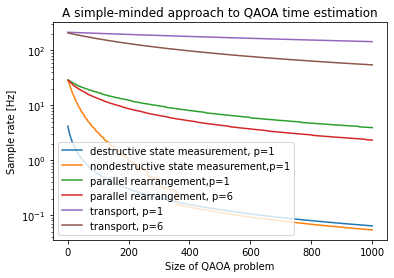

In [38]:
n_qaoa = np.linspace(1,1000,1000)
sr_qaoa1 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa1[jj] = sample_rate_destructive_sequential_really_simple(jj, 1, 3)
plt.plot(n_qaoa, sr_qaoa1)
sr_qaoa2 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa2[jj] = sample_rate_nondestructive_sequential_really_simple(jj, 1, 3)
plt.plot(n_qaoa, sr_qaoa2)
sr_qaoa3 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa3[jj] = sample_rate_nondestructive_parallel_really_simple(jj, 1, 3)
plt.plot(n_qaoa, sr_qaoa3)
sr_qaoa6 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa6[jj] = sample_rate_nondestructive_parallel_really_simple(jj, 6, 3)
plt.plot(n_qaoa, sr_qaoa6)
sr_qaoa4 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa4[jj] = sample_rate_transport_really_simple(jj, 1, 3)
plt.plot(n_qaoa, sr_qaoa4)
sr_qaoa5 = np.linspace(1,1000,1000)
for jj in np.arange(len(n_qaoa)):
    sr_qaoa5[jj] = sample_rate_transport_really_simple(jj, 6, 3)
plt.plot(n_qaoa, sr_qaoa5)




plt.yscale('log')

plt.xlabel('Size of QAOA problem')
plt.ylabel('Sample rate [Hz]')
plt.legend(['destructive state measurement, p=1','nondestructive state measurement,p=1', 'parallel rearrangement,p=1','parallel rearrangement, p=6','transport, p=1','transport, p=6'])
plt.title('A simple-minded approach to QAOA time estimation')
plt.savefig('simple_minded_qaoa_time_estimation.png')


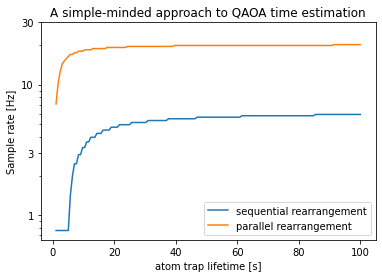

In [34]:
# look at the impact of changing background losses
# pin at N=66 (hilbert is n_atoms = 100 => n_nodes = 66 for d = 3, consider soon and later at p=1, d=3
# pin state measurement loss at 0.01

nondestructive_state_measurement_loss = 0.01
lifetimes = np.linspace(1,100,150)
srs_nondestructive_parallel = []
srs_nondestructive_sequential = []
for jj in np.arange(len(lifetimes)):
    atom_lifetime_short = lifetimes[jj]
    sr_jj_nd_s = sample_rate_nondestructive_sequential_really_simple(66, 1, 3)
    srs_nondestructive_sequential.append(sr_jj_nd_s)
    sr_jj_nd_p = sample_rate_nondestructive_parallel_really_simple(66, 1, 3)
    srs_nondestructive_parallel.append(sr_jj_nd_p)

plt.plot(lifetimes,srs_nondestructive_sequential)
plt.plot(lifetimes,srs_nondestructive_parallel)
plt.yscale('log')
plt.yticks([1,3,10,30],['1','3','10','30'])
plt.xlabel('atom trap lifetime [s]')
plt.ylabel('Sample rate [Hz]')
plt.legend(['sequential rearrangement','parallel rearrangement'])
plt.title('A simple-minded approach to QAOA time estimation')
plt.savefig('atom_lifetime_dependence.png')

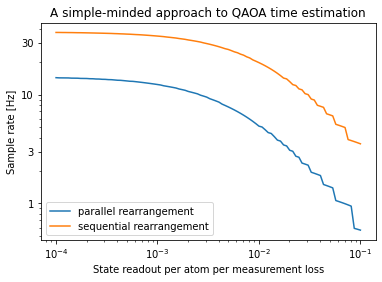

In [35]:
# look at the impact of changing state measurement losses
# pin at N=66 (hilbert is n_atoms = 100 => n_nodes = 66 for d = 3, consider soon and later at p=1, d=3
# pin atom lifetime at 30 s

atom_lifetime_short = 30
state_readout_losses = np.logspace(-4,-1,100)

srs_nondestructive_parallel = []
srs_nondestructive_sequential = []
for jj in np.arange(len(state_readout_losses)):
    nondestructive_state_measurement_loss = state_readout_losses[jj]
    sr_jj_nd_s = sample_rate_nondestructive_sequential_really_simple(66, 1, 3)
    srs_nondestructive_sequential.append(sr_jj_nd_s)
    sr_jj_nd_p = sample_rate_nondestructive_parallel_really_simple(66, 1, 3)
    srs_nondestructive_parallel.append(sr_jj_nd_p)

plt.plot(state_readout_losses,srs_nondestructive_sequential)
plt.plot(state_readout_losses,srs_nondestructive_parallel)
plt.yscale('log')
plt.xscale('log')
plt.yticks([1,3,10,30],['1','3','10','30'])
plt.xlabel('State readout per atom per measurement loss')
plt.ylabel('Sample rate [Hz]')
plt.legend(['parallel rearrangement','sequential rearrangement'])
plt.title('A simple-minded approach to QAOA time estimation')
plt.savefig('state_readout_loss_dependence.png')


overhead time is 1.21
0.0009800951485254839
0.0
0.052740999999999996
5.221357622864353e-05
number of cycles per load is 473995.0
18.959663266700453
18.960580952200377
